# Part 4

In [25]:
import numpy as np
np.random.seed(16)

import sklearn
from sklearn import datasets


import warnings
warnings.filterwarnings('ignore')

## Setting up a convex problem

We first consider the 2D case as this allows for pretty visuals. We then move over to a bigger problem.

In [26]:
from optilibrary import project

In [27]:
from optilibrary import ProjGD_Ball
# help(ProjGD_Ball)

A general equation of a paraboloid is stated with three terms:
$$P(x) = x^{T}Ax + Cx + d $$ 
for $A \in \mathbb{R}^{n\times{n}} \succ{0}$, $C\in\mathbb{R}^{n}$, and $d\in\mathbb{R}$

Using this rule, we generate data:

In [28]:
dim = 2
#Generate problem
A = datasets.make_spd_matrix(dim, random_state=16)
A = A

B = np.random.uniform(0, 1, dim)
B = B/np.sum(B)

d = np.random.uniform(-1, 0,1)

#goal: recover x given some observed y - values
P = lambda x: x.T.dot(x.T.dot(A)) + B.dot(x) + d
def gradP(x):
    temp = A.dot(x) + B
    return A.dot(x) + B

#### For projected gradient descent, the problem may be formulated as follows:
$$ \min_{x\in K} P(x) \text{    s.t.   } ||{x}||\leq{R} $$

where $K$ is a convex set. The gradient writes as 
$$\nabla{P} = 2Ax + C$$

For this project we consider 3 different convex sets.
- If $K$ is the $\ell_2$-ball, the projection may be expressed as:
 $$\Pi_{A}(x) = \frac{R}{max(||x||_2, R)}x$$ 
- Projection onto the simplex with sum R
- Projection onto the $\ell_1$-ball with radius R

The last 2 projections have algorithms proposed by Laurent Condat in his paper _Fast Projection onto the Simplex and the l1 Ball_




_(See Laurent Condat. Fast Projection onto the Simplex and the l1 Ball. Mathematical Programming, Series A, 2016, 158 (1), pp.575-585. ￿10.1007/s10107-015-0946-6. hal-01056171v2)_

#### For the Franke-Wolfe / Conditional gradient
When the convex set $K$ is the $\ell_2$-ball with radius R, we wish to solve:

\begin{equation}\tag{1}
s_{k+1} \in \underset{s \in B(0,R)}{\mathrm{argmin}} \big\{ f(x_k) + \langle\ \nabla f(x_k), s - x_k \rangle\ \big\}
\end{equation}

which is known to have explicit solution:
\begin{equation}\tag{2}
s_{k+1,j} = - R \frac{\text{sign}(\nabla f_j(x_k))|\nabla f_j(x_k)|}{||\nabla f(x_k)||_2}
\end{equation}
The weighting of the convex combination may be determined by exact linesearch:
\begin{equation}\tag{3}
\theta_k \in \text{argmin}_{\theta\in{[0,1]}} f(\theta_k s_{k+1} + (1-\theta) x_k)
\end{equation}

or by making use of a prescribed step size such as 
\begin{equation}\tag{4}
\theta_k = \frac{2}{k+2}
\end{equation}

In [29]:
R = 1
x0 = np.random.randn(dim)
maxiter = 200

We choose an arbitrary starting point $x_0$ on the boundary of the two balls with radius $R$ and run an iteration of PGD for each:

In [30]:
iters = []
errs = []
lball = [1, 2]
tol=0

for l in lball:
    proj_rule = lambda x, R: project(l, x, R)
    x = project(l, x0, R)
    it, e = ProjGD_Ball(x, P, gradP, step=0.1, max_iter=maxiter, R=R, q=2)
    iters.append(it)
    errs.append(e)
# errs = np.array(errs)

We plot the successive differences between iterates on normal and log scale

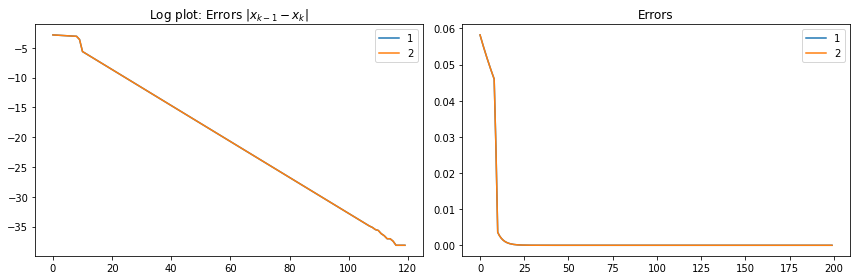

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,4), tight_layout=True)
plt.subplot(1,2,1)
for i in errs:
    plt.plot(np.log(i[1:]))
plt.legend(lball)
# plt.plot(np.log(errs))
plt.title(r'Log plot: Errors $|x_{k-1}-x_{k}|$')
plt.subplot(1,2,2)
for i in errs:
    plt.plot(i[1:])
plt.legend(lball)
plt.title('Errors');


The two balls render almost exactly the same results.

For a problem of small dimension as here, we may determine the exact solution by making use of scipy's _optimize_ library. 
The optimal solution $x^*$ is:

In [32]:
from scipy.optimize import minimize
res = minimize(P, x0, method='nelder-mead', options={'xatol':1e-8}) 
res.x

array([-0.17323659, -1.24429379])

We plot the true values of the iterates as black lines and for each of the $\ell_1$, $\ell_2$ balls, plot the evolution of the iterates.

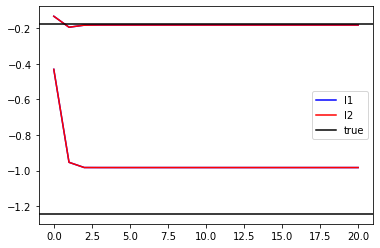

In [33]:
l1iters = iters[0]
l2iters = iters[1]

# l1iters[:,::10]
plt.plot(l1iters[0,::10].T, color='b', label='l1')
plt.plot(l1iters[1,::10].T, color='b')
plt.plot(l2iters[0,::10].T, color='r', label='l2')
plt.plot(l2iters[1,::10].T, color='r')
plt.axhline(res.x[0], color='k')
plt.axhline(res.x[1], color='k', label='true')
plt.legend();

As we first consider a 2D small problem, we may plot the evolution of the iterates in the $\ell_2$ ball in 3D space

In [34]:
n = 50
t = np.linspace(-2, 2, n)
X, Y = np.meshgrid(t,t)

In [35]:
vals = np.zeros(iters[1].shape[1])
for i in range(iters[1].shape[1]):
    vals[i] = P(iters[1][:,i])

temp = np.zeros(n*n)
Z = np.vstack((X.ravel(), Y.ravel()))
for i in range(Z.shape[1]):
    temp[i] = (P(Z[0:2, i]))
    
temp = temp.reshape((n,n))

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [37]:
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = R*(np.cos(u) * np.sin(v))
y = R*(np.sin(u) * np.sin(v))-1
z = np.cos(v)*R

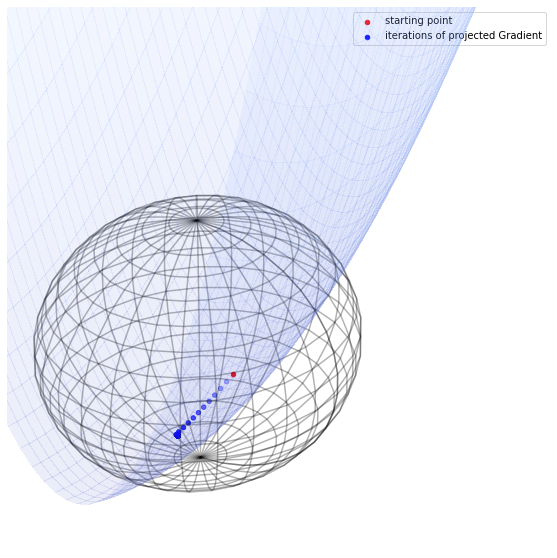

In [46]:
# %matplotlib qt
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(iters[1][0,0], iters[1][1,0], vals[0], s=20, c='r', label='starting point')
ax.scatter3D(iters[1][0,1:], iters[1][1,1:], vals[1:], s=20, c='b', label='iterations of projected Gradient')
ax.plot_surface(X, Y, temp, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.1)
ax.plot_wireframe(x, y, z, alpha=0.3, color='k')

#d=3
# ax.scatter3D(iters[1][0,0], iters[1][1,0], iters[1][2,0], s=5, c='r', label='starting point') #starting point
# ax.scatter3D(iters[1][0,1:], iters[1][1,1:], iters[1][2,1:], c='b', s=5, label='iterations of projected Gradient')

ax.set_xlim(-R-R/10,R+R/10)
ax.set_ylim(-R,R)
ax.set_zlim(-R,R-1/10)
ax.axis('off');
ax.legend();

We now compare the two methods on two different balls.

### For the $\ell_1$-ball

In [15]:
from optilibrary import argmin, extrpt
# help(argmin)
# help(extrpt)

In [16]:
from optilibrary import updatetheta, CondGD
# help(updatetheta)
# help(CondGD)

In [17]:
def rules(lball, R):
    theta_rule = lambda k, sk: updatetheta('fixed', k, sk, f=P, gradf=gradP)
    extr_rule = lambda d, R: extrpt(d, R, lball)
    argm_rule = lambda x, R: argmin(x, R, lball)
    proj_rule = lambda x, R: project(lball, x, R)

    return theta_rule, extr_rule, argm_rule, proj_rule

theta_rule, extr_rule, argm_rule, proj_rule = rules(lball=1, R=R)
x0 = extrpt(dim, R, 1)
maxit=100
R=1.25
step = 0.01
tol = 0

iter_cond, err_cond = CondGD(f=P, gradf=gradP, R=R, pick_theta_rule=theta_rule, extr_pt_rule=extr_rule, argminrule=argm_rule, dim=dim, maxit=maxit)
iter_proj, err_proj = ProjGD_Ball(x0, P, gradP, step=step, max_iter=maxit, R=R, q=1)

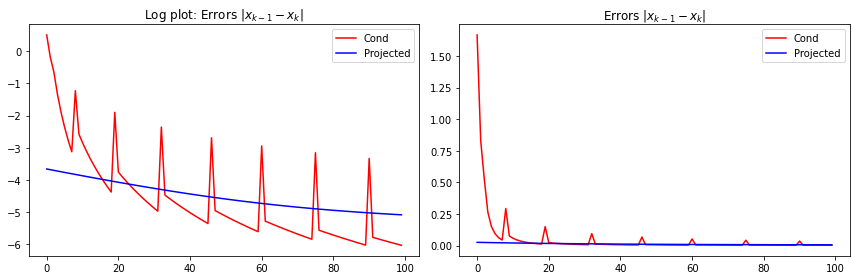

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4), tight_layout=True)
plt.subplot(1,2,1)
plt.plot(np.log(err_cond[1:]), 'r')
plt.plot(np.log(err_proj[1:]), 'b')
plt.legend(('Cond', 'Projected'))
plt.title(r'Log plot: Errors $|x_{k-1}-x_{k}|$')
plt.subplot(1,2,2)
plt.plot((err_cond[1:]), 'r')
plt.plot((err_proj[1:]), 'b')
plt.legend(('Cond', 'Projected'))
plt.title(r'Errors $|x_{k-1}-x_{k}|$');

Both iterates converge fairly quickly when considering successive differences in the norm:

In [19]:
print(f"Final Difference: \nCond: {err_cond[-1]}\nProj: {err_proj[-1]}")

Final Difference: 
Cond: 0.002388635446043774
Proj: 0.006167361498751566


We note, however, that CGD converges faster for this ball

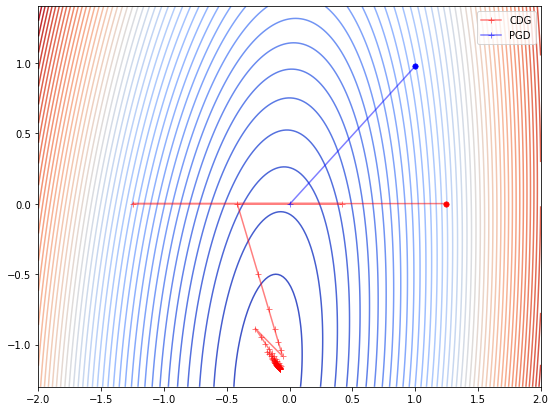

In [20]:
# t = np.linspace(-2, 2, 200)
X, Y = np.meshgrid( np.linspace(-2, 2, 200) , np.linspace(-1.3, 1.4, 200))
Z = np.zeros_like(X)
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i,j] = P(np.array([X[i,j], Y[i,j]]))
# Z = np.reshape(Z, X.shape)
plt.figure(figsize=(9, 7))
plt.contour(X, Y, Z, 50, cmap='coolwarm');
plt.plot(iter_cond[:,0], iter_cond[:, 1], marker = '+', color = 'r', alpha=0.5, label='CDG')
plt.plot(iter_cond[0,0], iter_cond[0,1], marker='.', markersize=10, color='r')
# plt.xlim(np.min(iter_cond[:,0])-0.5, np.max(iter_cond[:,1])+0.5);

plt.plot(iter_proj[:,0], iter_proj[:, 1], marker = '+', color = 'b', alpha=0.5, label='PGD')
plt.plot(iter_proj[0,0], iter_proj[0,1], marker='.', markersize=10, color='b')
plt.legend();

### For the $\ell_2$-ball

In [21]:
theta_rule, extr_rule, argm_rule, proj_rule = rules(lball=2, R=R)

maxit=100
R=1.25
step = 0.05
tol = 0

iter_cond, err_cond = CondGD(f=P, gradf=gradP, R=R, pick_theta_rule=theta_rule, extr_pt_rule=extr_rule, argminrule=argm_rule, dim=dim, maxit=maxit)
iter_proj, err_proj = ProjGD_Ball(x0, P, gradP, step=step, max_iter=maxit, R=R, q=2)

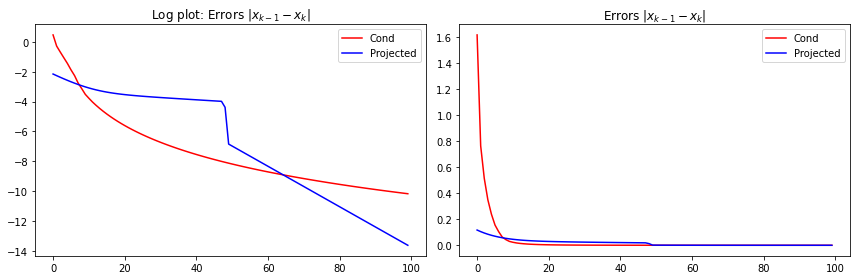

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4), tight_layout=True)
plt.subplot(1,2,1)
plt.plot(np.log(err_cond[1:]), 'r')
plt.plot(np.log(err_proj[1:]), 'b')
plt.legend(('Cond', 'Projected'))
plt.title(r'Log plot: Errors $|x_{k-1}-x_{k}|$')
plt.subplot(1,2,2)
plt.plot(err_cond[1:], 'r')
plt.plot(err_proj[1:], 'b')
plt.legend(('Cond', 'Projected'))
plt.title(r'Errors $|x_{k-1}-x_{k}|$');

Here PGD seems to converge almost immediately and then stagnates. This happened even for multiple values of the step parameter

In [23]:
print(f"Final Difference: \nCond: {err_cond[-1]}\nProj: {err_proj[-1]}")

Final Difference: 
Cond: 3.806120191684874e-05
Proj: 1.1969725472280687e-06


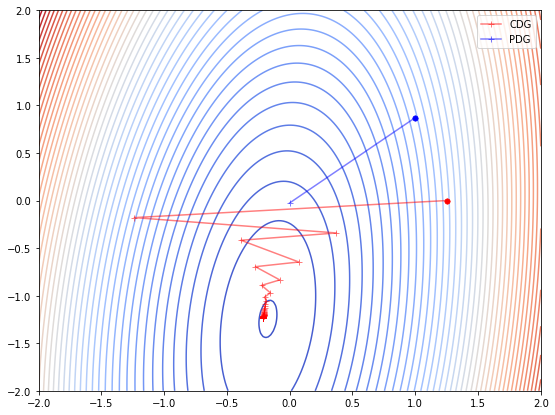

In [24]:
X, Y = np.meshgrid( np.linspace(-2, 2, 200) , np.linspace(-2, 2, 200))
Z = np.zeros_like(X)
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i,j] = P(np.array([X[i,j], Y[i,j]]))
# Z = np.reshape(Z, X.shape)
plt.figure(figsize=(9, 7))
plt.contour(X, Y, Z, 50, cmap='coolwarm');
plt.plot(iter_cond[:,0], iter_cond[:, 1], marker = '+', color = 'r', alpha=0.5, label='CDG')
plt.plot(iter_cond[0,0], iter_cond[0,1], marker='.', markersize=10, color='r')

plt.plot(iter_proj[:,0], iter_proj[:, 1], marker = '+', color = 'b', alpha=0.5, label='PDG')
plt.plot(iter_proj[0,0], iter_proj[0,1], marker='.', markersize=10, color='b');
plt.legend();
# plt.xlim(np.min(iter_cond[:,0])-0.5, np.max(iter_cond[:,1])+0.5);